In [37]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [38]:
import zipfile

with zipfile.ZipFile('/content/BBC News Train.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_data')
with open("extracted_data/BBC News Train.csv", 'r') as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"The second line (first data point) looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

ArticleId,Text,Category

The second line (first data point) looks like this:

1833,worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in e

In [39]:
# Define the global variables
VOCAB_SIZE = 1000
EMBEDDING_DIM = 16
MAX_LENGTH = 120
TRAINING_SPLIT = 0.8

In [40]:
data_dir = "/content/extracted_data/BBC News Train.csv"
data = np.loadtxt(data_dir, delimiter=',', skiprows=1, dtype='str', comments=None)
print(f"Shape of the data: {data.shape}")
print(f"{data[0]}\n{data[1]}")

Shape of the data: (1490, 3)
['1833'
 'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures 

In [41]:

# Test the function
print(f"There are {len(data)} sentence-label pairs in the dataset.\n")
print(f"First sentence has {len((data[0,1]).split())} words.\n")
print(f"The first 5 labels are {data[:5,2]}")


There are 1490 sentence-label pairs in the dataset.

First sentence has 301 words.

The first 5 labels are ['business' 'business' 'business' 'tech' 'business']


In [43]:
def train_val_datasets(data):
    # Define the training size (e.g., 80% of the total data)
    train_size = int(0.8 * len(data))

    # Slice the dataset to get texts and labels
    texts = data[:, 1]
    labels = data[:, 2]

    # Split the sentences and labels into train/validation sets
    train_texts = texts[:train_size]
    validation_texts = texts[train_size:]
    train_labels = labels[:train_size]
    validation_labels = labels[train_size:]

    # Create the train and validation datasets from the splits
    train_dataset = tf.data.Dataset.from_tensor_slices((train_texts, train_labels))
    validation_dataset = tf.data.Dataset.from_tensor_slices((validation_texts, validation_labels))


    return train_dataset, validation_dataset

# Create the datasets
train_dataset, validation_dataset = train_val_datasets(data)
print('Name:Joyc Beulah R       Register Number: 212222230058')
print(f"There are {train_dataset.cardinality()} sentence-label pairs for training.\n")
print(f"There are {validation_dataset.cardinality()} sentence-label pairs for validation.\n")

Name:Joyc Beulah R       Register Number: 212222230058
There are 1192 sentence-label pairs for training.

There are 298 sentence-label pairs for validation.



In [45]:
def standardize_func(sentence):
    # List of stopwords
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "her", "here",  "hers", "herself", "him", "himself", "his", "how",  "i", "if", "in", "into", "is", "it", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she",  "should", "so", "some", "such", "than", "that",  "the", "their", "theirs", "them", "themselves", "then", "there", "these", "they", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we",  "were", "what",  "when", "where", "which", "while", "who", "whom", "why", "why", "with", "would", "you",  "your", "yours", "yourself", "yourselves", "'m",  "'d", "'ll", "'re", "'ve", "'s", "'d"]

    # Sentence converted to lowercase-only
    sentence = tf.strings.lower(sentence)

    # Remove stopwords
    for word in stopwords:
        if word[0] == "'":
            sentence = tf.strings.regex_replace(sentence, rf"{word}\b", "")
        else:
            sentence = tf.strings.regex_replace(sentence, rf"\b{word}\b", "")

    # Remove punctuation
    sentence = tf.strings.regex_replace(sentence, r'[!"#$%&()\*\+,-\./:;<=>?@^_`{|}~\']', "")

    return sentence

In [46]:


def fit_vectorizer(train_sentences, standardize_func):

    # Instantiate the TextVectorization class, passing in the correct values for the parameters
    vectorizer = tf.keras.layers.TextVectorization(
        standardize=standardize_func,            # Custom standardization function
        max_tokens=VOCAB_SIZE,                   # Maximum vocabulary size
        output_sequence_length=MAX_LENGTH        # Truncate sequences to this length
    )

    # Adapt the vectorizer to the training sentences
    vectorizer.adapt(train_sentences)


    return vectorizer


In [47]:
# Create the vectorizer
text_only_dataset = train_dataset.map(lambda text, label: text)
vectorizer = fit_vectorizer(text_only_dataset, standardize_func)
vocab_size = vectorizer.vocabulary_size()
print('Name:Joyce Beulah R      Register Number: 212222230058  ')
print(f"Vocabulary contains {vocab_size} words\n")

Name:Joyce Beulah R      Register Number: 212222230058  
Vocabulary contains 1000 words



In [22]:
def fit_label_encoder(train_labels, validation_labels):

    # Concatenate the training and validation label datasets
    labels = train_labels.concatenate(validation_labels)

    # Instantiate the StringLookup layer without any OOV token
    label_encoder = tf.keras.layers.StringLookup(num_oov_indices=0)

    # Adapt the StringLookup layer on the combined labels dataset
    label_encoder.adapt(labels)


    return label_encoder


In [48]:
train_labels_only = train_dataset.map(lambda text, label: label)
validation_labels_only = validation_dataset.map(lambda text, label: label)

label_encoder = fit_label_encoder(train_labels_only,validation_labels_only)
print('Name: Joyce Beulah     Register Number: 212222230058    ')
print(f'Unique labels: {label_encoder.get_vocabulary()}')


Name: Joyce Beulah     Register Number: 212222230058    
Unique labels: ['sport', 'business', 'politics', 'entertainment', 'tech']


In [49]:
def preprocess_dataset(dataset, vectorizer, label_encoder, batch_size=32):
    # Define a mapping function to preprocess each (text, label) pair
    def preprocess(text, label):
        text = vectorizer(text)                # Vectorize the text
        label = label_encoder(label)           # Encode the label
        return text, label

    # Map the preprocessing function to the dataset and batch it
    dataset = dataset.map(preprocess).batch(batch_size)

    return dataset
# Preprocess your dataset
train_proc_dataset = preprocess_dataset(train_dataset, vectorizer, label_encoder)
validation_proc_dataset = preprocess_dataset(validation_dataset, vectorizer, label_encoder)

train_batch = next(train_proc_dataset.as_numpy_iterator())
validation_batch = next(validation_proc_dataset.as_numpy_iterator())
print('Name: Joyce Beulah R     Register Number: 212222230058      ')
print(f"Shape of the train batch: {train_batch[0].shape}")
print(f"Shape of the validation batch: {validation_batch[0].shape}")

Name: Joyce Beulah R     Register Number: 212222230058      
Shape of the train batch: (32, 120)
Shape of the validation batch: (32, 120)


In [50]:
def create_model():

    # Define your model
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(MAX_LENGTH,)),
        tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    # Compile model. Set an appropriate loss, optimizer and metrics
    model.compile(
        loss='sparse_categorical_crossentropy',  # or 'categorical_crossentropy' if labels are one-hot encoded
        optimizer='adam',
        metrics=['accuracy']
    )

    return model

model = create_model()


In [51]:
example_batch = train_proc_dataset.take(1)

try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (32, 5)


In [52]:

history = model.fit(train_proc_dataset, epochs=30, validation_data=validation_proc_dataset)


Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.2470 - loss: 1.6003 - val_accuracy: 0.2550 - val_loss: 1.5835
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.3080 - loss: 1.5607 - val_accuracy: 0.3322 - val_loss: 1.5469
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.3877 - loss: 1.5070 - val_accuracy: 0.4396 - val_loss: 1.4808
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.4788 - loss: 1.4220 - val_accuracy: 0.5067 - val_loss: 1.3899
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.5791 - loss: 1.3014 - val_accuracy: 0.6107 - val_loss: 1.2686
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.6819 - loss: 1.1498 - val_accuracy: 0.6812 - val_loss: 1.1238
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.7809 - loss: 0.9849 - val_accuracy: 0.7752 - val_loss: 0.9657
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8680 - loss: 0.8217 - val_accuracy: 0.8557 - 

Name: Joyce Beulah R   Register Number: 212222230058 


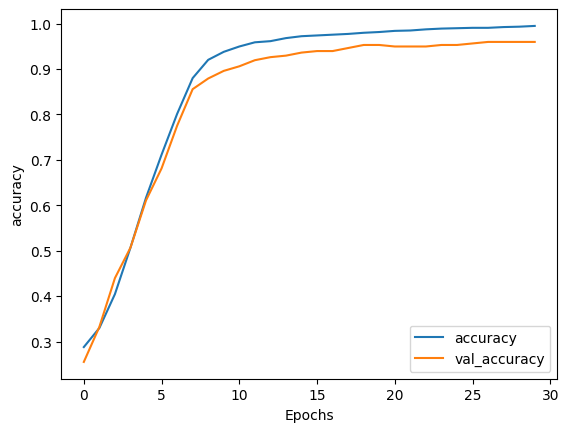

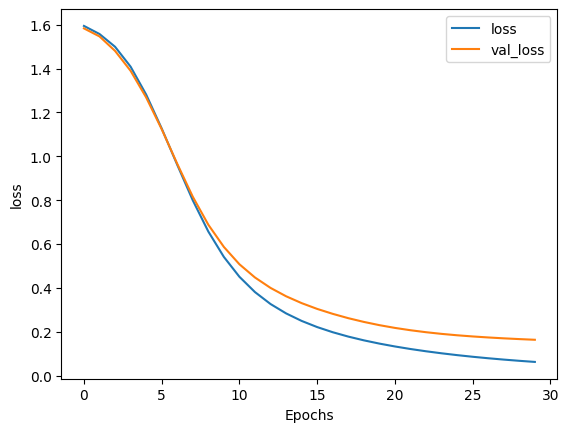

In [53]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
print('Name: Joyce Beulah R   Register Number: 212222230058 ')
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")